# M2 | Exploration Notebook

In this notebook, you will do a first exploration of the data set that you will use for your project. One part of this exploration is guided, i.e. we will ask you to solve specific questions (task 1-3). The other part is open, i.e. we will ask you to come up with your own exploration ideas (task 4). 

Please upload your solved notebook to Moodle (under Milestone 2 Submission)adding your SCIPER number in title, example: m2-lernnavi-456392.ipynb


## Brief overview of Lernnavi
[Lernnavi](https://www.lernnavi.ch) is an instrument for promoting part of the basic technical study skills in German and mathematics.


For the guided part of the exploration we will focus on the three main tables:
* *users*: demographic information of users.
* *events*: events done by the users in the platform.
* *transactions*: question and answer solved by user.

### Users
* user_id: unique identifier of user in database.
* gender: only three values: M male, F female or missing. 
* canton: swiss canton.
* class_level: school year in swiss system.


### Events
* event_id: unique identifier of event in database.
* user_id: user who peformed the event.
* timestamp: timestamp of event.
* category: classification of action (task, general, statistics, etc).
* action: type of action performed.
* event_type: whether the students viewed or clicked in the event.
* transaction_token: used to link to transactions table.
* session_id: session during which the event took place.
* tracking_data: optional content associated to this event (e.g., the new points mastered for a topic).


### Transactions
* transaction_id: unique identifier of transaction in database.
* transaction_token: used to link to events table.
* user_id: user who performed the transaction.
* document_id: document that was answered in transaction.
* document_version: version of document that was answered.
* evaluation: whether the user answered correctly or not. It is possible that it was only partially right. 
* input: answer the user gave.
* start_time: timestamp of when the user started answering.
* commit_time: timestamp of when the user submitted the answer.
* user_agent: the browser that the user used.
* validation: used to validate the format of the input.
* solution: solution to question.
* type: type of question that was answered. 


In [1]:
# Import the tables of the data set as dataframes.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.metrics import normalized_mutual_info_score
import seaborn as sns


DATA_DIR = './MLBD - Lernnavi Data' #You many change the directory

users = pd.read_csv('{}/users.csv.gz'.format(DATA_DIR))
events = pd.read_csv('{}/events.csv.gz'.format(DATA_DIR))
transactions = pd.read_csv('{}/transactions.csv.gz'.format(DATA_DIR))

## Task 1: Simple Statistics

In this task you are asked to do a first coarse exploration of the data set, using simple statistics and visualizations.

#### a) How many distinct participants do we have in the data set?


In [2]:
## Your code goes here
user_nb = users["user_id"].nunique()
print("There are {} participants in the dataset".format(user_nb))

There are 13695 participants in the dataset


#### b) How many transactions were done per user? Please provide a visualization and discuss the distribution.

<AxesSubplot:>

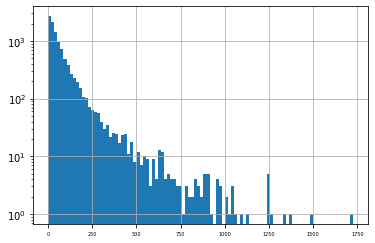

In [3]:
# Your code goes here
transactions.groupby("user_id").size().hist(bins = 100, log = True)

This distribution shows that most user have less than 250 transactions to their name, and the higher the transaction count, the fewer users there are, in an inversely proportional way. This distribution is right skewed, with a long tail, again typical of inversely proportional distribution. (Which is also why I chose a log scale for the histogram, as it is really difficult to see these kinds of distributions with a linear scale)

#### c) Which are the 10 most popular event actions? Please provide a visualization of the frequency of the top 10 event actions.

Hint: See actions in table events.

<AxesSubplot:xlabel='action'>

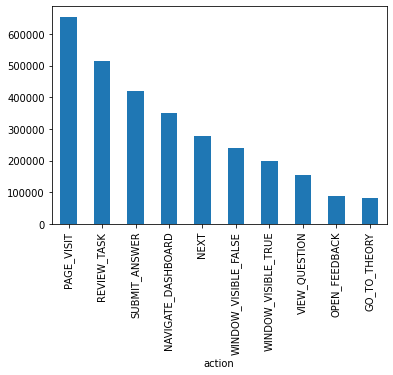

In [4]:
# Your code goes here
events.groupby("action").size().nlargest(10).plot.bar()

The top 10 shows an almost linear descent in the number of actions, going from more than 600'000 events for PAGE_VISIT down to slightly less than 100'000 for GO_TO_THEORY. 

## Task 2: Static Analysis

In this second task, you will do a univariate an multivariate exploration of some aggregated features.

#### a) Build a data frame containing one row per user:

``[user_id, gender, num_events, num_questions, percentage_correct, num_reading]``


The features are defined as follows:

- **num_questions**: total number of questions the student answered (hint: action event = submit answer)

- **num_events**: total number of events of the student  

- **percentage_correct**: number of correct answers/total number of answers (hint: evaluation = correct). If desired, you may assign a weight of 0.5 to partially correct answers. 

- **num_reading**: total number of theory reading events  (hint: action event = go to theory)

Assumptions: As I learned on the Q&A Forums, the events table was created after the transaction table; Therefor, some users have entries in the transactions table, but not the events one. So instead of using the action event SUBMIT_ANSWER to count the number of questions answered in the event table, I simply count the number of rows in the transaction table that have a non-NaN evaluation. That way, these users' questions are properly acounted for, and the num_questions feature is consistent with the percentage_correct feature, which is also computed with the transaction table.

In [5]:
# Your code for building the data frame here
#Get the user_id and gender to start the requested dataframe
df = users[["user_id","gender"]]

#Get all the transactions rows with an evaluation, and count how many there are per user with a groupb and size().
#Then, merges it with the existing dataframe.
df = df.merge(transactions[["user_id","evaluation"]].dropna()
              .groupby("user_id").size().rename('num_questions'), on = "user_id", how = "left")
#df['num_questions'] = df['num_questions'].fillna(0)

#Similarly, get the number of events per user with a groupby and size(), then merge.
df = df.merge(events.groupby("user_id").size().rename('num_events'), on = "user_id", how = "left")
#df['num_events'] = df['num_events'].fillna(0)

#Here I convert the evaluations to numbers (1 for correct, 0.5 for partially correct, 0 for wrong), and I sum them up per user to get
#their score; then I divide it by the number of questions to get the percentage_correct per user
df = df.merge(transactions[["user_id","evaluation"]].dropna()
              .replace(["CORRECT","PARTIAL","WRONG"],[1,0.5,0])
              .groupby("user_id").sum(), on = "user_id", how = "left")
df["evaluation"] = 100* (df["evaluation"]/df["num_questions"])
df = df.rename(columns={"evaluation": "percentage_correct"})

#Filter the events table by action GO_TO_THEORY, and sum up how many row per user with a groupby and size()
df = df.merge(events[events["action"] == "GO_TO_THEORY"].groupby("user_id").size().rename('num_reading'), on = "user_id", how = "left")
#df['num_reading'] = df['num_reading'].fillna(0)

df.head(5)

,user_id,gender,num_questions,num_events,percentage_correct,num_reading
0,387604,NaN,97.0,2606.0,53.608247,368.0
1,387605,NaN,510.0,3331.0,64.803922,33.0
2,387608,NaN,151.0,866.0,82.119205,23.0
3,387615,MALE,111.0,492.0,72.072072,10.0
4,387643,NaN,11.0,4.0,68.181818,NaN


b) Perform a univariate analysis (including descriptive statistics and visualizations) for the five features (gender, num_events, num_questions, percentage_correct, num_reading) of your dataframe. Please check the lecture slides regarding information on how to perform a univariate analysis for categorical and numerical features. Discuss your results: how are the features distributed? Are there any anomalities?

[nan 'MALE' 'FEMALE' 'STAR']
NaN       4413
FEMALE    5294
MALE      3524
STAR       464
Name: gender, dtype: int64


<AxesSubplot:>

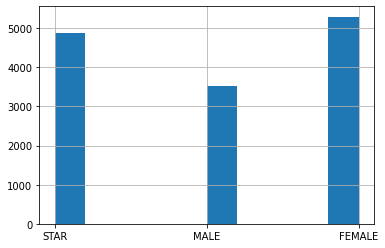

In [6]:
# Gender
gender = df["gender"]
print(gender.unique())
print("NaN       {}".format(gender.isna().sum()))
print(gender.value_counts())
gender.fillna("STAR",inplace=True)
gender.hist()

Immediately, we can see there is a mix of NaN numbers and STAR for missing values. For the histogram, I grouped them both to have a meaningful comparison, as NaN are ignored by pandas with histograms. 
Speaking of, we can see there is actually more missing values than MALE, and only slightly more FEMALE.

count    10113.000000
mean       342.683576
std        577.384662
min          1.000000
25%         79.000000
50%        173.000000
75%        365.000000
max      10044.000000
Name: num_events, dtype: float64


<AxesSubplot:>

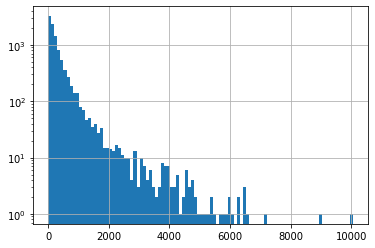

In [7]:
#num_events

num_events = df["num_events"]
print(num_events.describe())
num_events.hist(bins = 100, log = True)

As with the number of transactions per user, the number of events per user follow an inversely proportional distribution, which is very right-skewed. 75% of the users have less than 273 events to their names, with a long tail ending in a few outliers having 6000 to 10'000 events. (Which is also why I chose a log scale for the histogram, as it is really difficult to see these kinds of distribution with a linear scale) This is as expected after seeing the transactions per user distribution, as they are closely related.

count    10217.000000
mean        49.243320
std         78.507881
min          1.000000
25%         11.000000
50%         25.000000
75%         55.000000
max       1052.000000
Name: num_questions, dtype: float64


<AxesSubplot:>

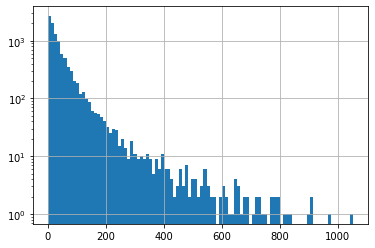

In [8]:
#num_questions

num_questions = df["num_questions"]
print(num_questions.describe())
num_questions.hist(bins = 100, log = True)

This distribution is almost identical to the num_events one (apart from the scaling); A very right-skewed, inversely proportional distribution, with 75% of user answering less than 41 question, and a long tail ending in outliers reaching the thousand. It is logical that it follow the same distribution as the number of events and transactions per user, as they are closely linked: users more active likely answered more questions, and users less active probably answered less. (And for the same reasons as above, this distribution is shown on a log graph)

count    10217.000000
mean        65.589887
std         15.215546
min          0.000000
25%         57.692308
50%         66.666667
75%         75.000000
max        100.000000
Name: percentage_correct, dtype: float64


<AxesSubplot:>

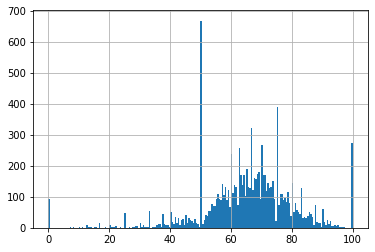

In [9]:
#percentage_correct

percentage_correct = df["percentage_correct"]
print(percentage_correct.describe())
percentage_correct.hist(bins = 200)

This distribution, overall, follows a slightly left-skewed gaussian centered at around 66%. This is a very common distribution amongst exam results, particularly in Switzerland as 66% is the passing grade according to the Federal scale for grading students. However, there are some unexpected spikes: at 100%, it can be explained by the fact that 100% is the maximum grade; therefore, the (theoretical) gaussian distribution that would go past this point is aggregated here. At 0%, those are the people who typically registered and gave up partway through, before any evaluation. But then at 50%, there is quite a big spike, which I don't see any obvious reason why. Maybe it is rounding, maybe students who answered randomly get on average 50% of the questions correct, but I don't have a clear explanation for such a big spike.

count    4605.000000
mean       17.534419
std        53.745595
min         1.000000
25%         2.000000
50%         6.000000
75%        14.000000
max      2404.000000
Name: num_reading, dtype: float64


<AxesSubplot:>

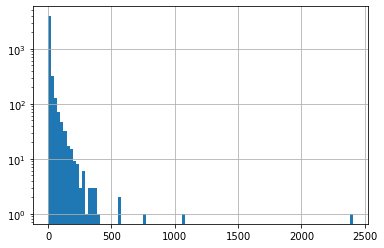

In [10]:
#num_reading

num_reading = df["num_reading"]
print(num_reading.describe())
num_reading.hist(bins = 100, log = True)

Finally, this distribution is surprising compared to the number of events/transactions per user and the questions answered per user, because it is so heavily skewed to the right it doesn't have a tail of sorts. The vast majority of students have less than 10 GO_TO_THEORY transactions, after which there are only a handful of outliers that have between 500 and 2500.

c) Come up with two additional features on your own and add them to the dataframe. Please provide an explanation/description of your features as well as an argument/hypothesis of why you think these features are interesting to explore.

In [11]:
# Your code for computing the features and adding them to the df goes here
commit_times = transactions[["user_id","commit_time"]].drop_duplicates(subset=["user_id"], keep = "last")
df = df.merge(commit_times, on = "user_id", how = "left")
df = df.merge(users[["user_id","class_level"]], on = "user_id", how = "left")


Feature: commit_time
I want to use this feature in two ways: First, I want to know over which period the data has been collected, as it could influence the interpretations of other features (e.g. if it was collected only at the beginning of a school year, over multiple years, etc). Second, I think commit_time can be used to estimate the activity of the students, and I hypothesis that low activity will line up with school vacations.

Feature: class_level
I want to know if there are significant biases in the sampled students, as there are many different class level in the dataset; As Gymnasium is the most common choice for advanced secondary studies here in Switzerland, I expect a heavy bias of number of students here.

d) Perform a univariate analysis of your features (including descriptive statistics and visualization). What can you observe? Do the results confirm your hypotheses?

<AxesSubplot:>

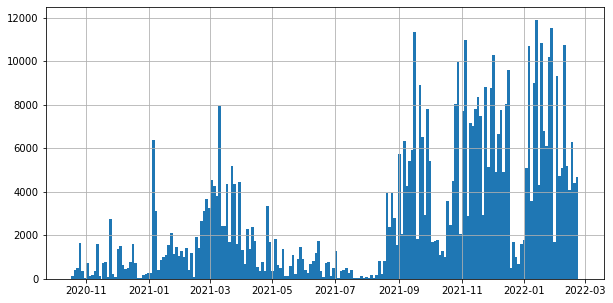

In [12]:
# Your code for univariate analysis goes here
pd.to_datetime(transactions["commit_time"], unit='ms').hist(bins =200, figsize = (10,5))

As expected, the activity of users lines up nicely with vacations in Switzerland, as we get drops in number of commits during the Automn break (end of Sept.-begining of Nov.), Christmas break (end of Dec.-beginning of January), Spring break (April), and Summer break (June-August). I would guess there were more students the second year they were collecting data, as the activity is higher across the board during the 2021-2022 year compared to the 2020-2021 year.

<AxesSubplot:ylabel='class_level'>

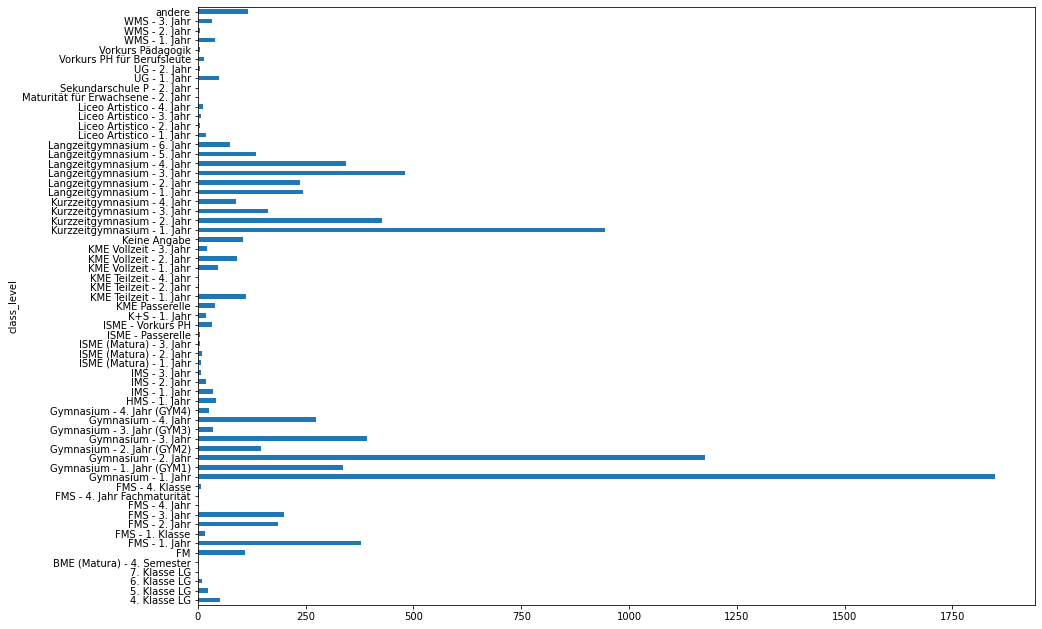

In [13]:
df.groupby("class_level").size().plot(kind='barh',figsize = (15,11))

As expected, most of the students come from the Gymnasium, which is the advanced secondary education in Switzerland; it lasts between 3 to 6 years depending on the place. Comparing calss levels with similar names through the years (thus assuming they are from the same place/Canton), we can see that there are less and less students, as a percentage of them fail each year. However, there are some exceptions, like the Langzeitgymnasium, which in year 3 gets a significant boost of activity; this might be another sign of an increase in users of the application, that I theorized previously for the 2021-202 year.

e) Perform a multivariate analysis for two pairs of features of your choice. Please provide a metric and a visualization for both pairs. Please discuss: why did you choose these two pairs? What was your hypothesis? Do the results confirm your hypothesis?

Hypothesis: The first pair is the relation between the number of events and the percentage of correct answer of each users. I want to see if more active users get better results, but I also expect users with even more activity to have lower/average grade, as it show they struggle to answer questions.

                    num_events  percentage_correct
num_events            1.000000            0.052007
percentage_correct    0.052007            1.000000
Normalized Mutual Information Coefficient: 0.7913424716456813


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/cluster/_supervised.py:65: UserWarning: Clustering metrics expects discrete values but received multiclass values for label, and continuous values for target
  warnings.warn(msg, UserWarning)


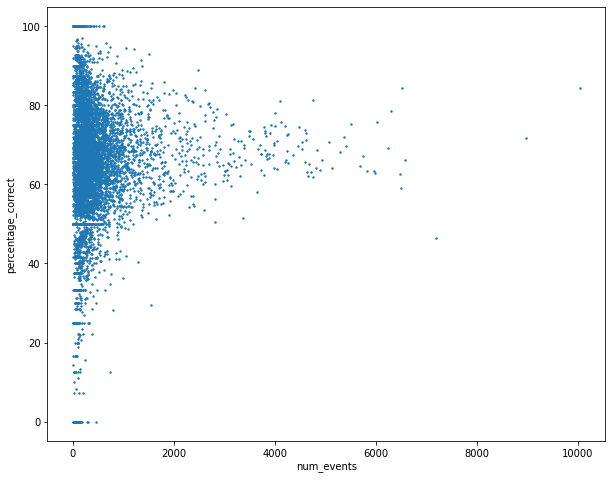

In [14]:
# Your code for multivariate analysis goes here
df.plot.scatter(x='num_events', y='percentage_correct', s = 2, figsize = (10,8))
print(df[["num_events","percentage_correct"]].corr(method="pearson"))
print("Normalized Mutual Information Coefficient: {}"
      .format(normalized_mutual_info_score(df.dropna()["num_events"].tolist(), df.dropna()["percentage_correct"].tolist())))

Analysis: The results are partially as expected: On one hand, there doesn't seem to be much difference in the number of events between students who scored very well, and student who failed to get a passing grade of 4 out of 6 (66%). On the other, I correctly guessed that a increasigly high number of event would yield scores close to 4. As it isn't a linear relationship, the Pearson's coefficient is very close to 0; but the normalized mutual information coefficient is much higher, at 0.68 (maximum being 1, minimum 0). It is interesting to note that some percentages have more grades than others, I suspect it is due to rounding of grades, as the percentages (50%, 33%, 25% out of 100%) line up with rounded grades on a scale of 6 (3, 2, 1 out of 6).

Hypothesis: The second pair is the repartition of grades across class year. I expect it to follow a gaussian centered at around 66% everywhere, as it is the usual repartition of grades in Switzerland, thus having those two features be uncorrelated. But maybe it will on the contrary show interesting results at different years, like a different grading scheme at younger years, ect. 

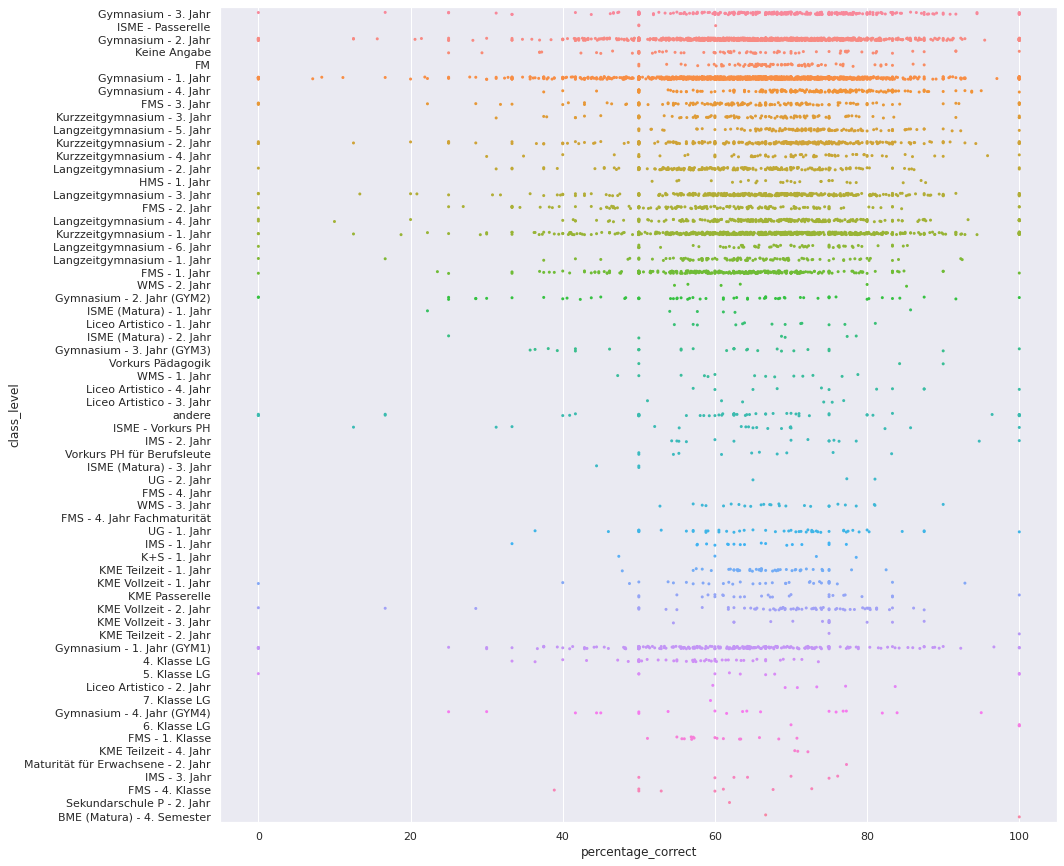

In [15]:
sns.set(rc = {'figure.figsize':(15,15)})
g=sns.stripplot(x="percentage_correct", y="class_level",data=df, s=3)


Analysis: My hypothesis seems to be correct, as all years are centered around 66%, and following a gaussian-like repartition of grades. As said in part 2.d), most of the students come from the 3-to-6-years Gymnasium, which is the advanced secondary education in Switzerland. Other than that, the results are very much as expected, and no class level show an anormal distribution.

# Task 3: Time-Series Analysis

In the last task, you will perform a time-series analysis.


#### a) Build a data frame containing one row per user per week:

``[user_id, week, num_events, num_questions, percentage_correct, num_reading]``


The features are defined as follows:

- **num_questions**: total number of questions the student answered **per week**(hint: action event = submit answer).

- **num_events**: total number of events of the student per week.

- **percentage_correct**: number of correct answers/total number of answers  **per week** (hint: evaluation = correct). If desired, you may assign a weight of 0.5 to partially correct answers.

- **num_reading**: total number of theory reading events **per week** (hint: action event = go to theory).

Where week 0 is the first week the specific user solved a task in the platform, i.e., the user's earliest entry in the transactions table.

Hint: You may extract the week of the year (dt.week) from the timestamps. 

You can limit the number of weeks to 13, i.e. for each user we just look at the first 13 weeks of data.
Yoy may change and justify your choice for the number of weeks.

In [16]:
# Your code for building the dataframe goes here
#I assume "commit_time" can be used as a timestamp for the transaction
#First, I convert the float64 timestamp to a datetime object, then I add new columns for year and week number.
transactions["commit_time_dt"] = pd.to_datetime(transactions["commit_time"], unit='ms')
transactions["week"] = transactions["commit_time_dt"].dt.week
transactions["year"] = transactions["commit_time_dt"].dt.year

#Then I get the num_questions per week by dropping rows where the evaluation is NaN (same as 2.a)),
# and following up with a groupby and size() on the user_id, year and week.
df_weekly = transactions[["user_id","year","week","evaluation"]].dropna().groupby(["user_id","year","week"]).size().reset_index(name='num_questions')


#Same principle for the events table to get num_events per week, but this time merging with the previously created dataframe
events["timestamp_dt"] = pd.to_datetime(events["timestamp"], unit='ms')
events["week"] = events["timestamp_dt"].dt.week
events["year"] = events["timestamp_dt"].dt.year

df_weekly = df_weekly.merge(events[["user_id","year","week"]].dropna().groupby(["user_id","year","week"]).size()
              .reset_index(name='num_events'), on = ["user_id","year","week"], how = "left")


#Similarly to 2.a), I convert the evaluations to a number, and then sum them up per week to get the number of correct question;
#After that, I can simply divide it by the number of questions per week to get the percentage_correct per week.
df_weekly = df_weekly.merge(transactions[["user_id","year","week","evaluation"]].dropna()
              .replace(["CORRECT","PARTIAL","WRONG"],[1,0.5,0])
              .groupby(["user_id","year","week"]).sum().reset_index(), on = ["user_id","year","week"], how = "left")
df_weekly["evaluation"] = 100* (df_weekly["evaluation"]/df_weekly["num_questions"])
df_weekly = df_weekly.rename(columns={"evaluation": "percentage_correct"})


#Filter the event table by actions GO_TO_THEORY, then sum up the number per week with a groupby and size(), then merge it.
df_weekly = df_weekly.merge(events[events["action"] == "GO_TO_THEORY"].groupby(["user_id","year","week"]).size().reset_index(name='num_reading'),
              on = ["user_id","year","week"], how = "left")

#What I'm doing here is sorting the dataframe on user_id, year, then week, that way I can just take the first 13 row of each user_id
#to get their first 13 weeks of data
df_weekly = df_weekly.sort_values(by = ["user_id","year","week"]).groupby('user_id').head(13).reset_index(drop=True)

#This here is to reset the week number to go from 0 to 12
df_weekly["week"] = df_weekly.groupby('user_id').cumcount()

#Cleaning up the year column as we don't need it anymore
df_weekly = df_weekly.drop(columns = ["year"])
df_weekly.head(15)


/tmp/ipykernel_950/4160163868.py:5: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  transactions["week"] = transactions["commit_time_dt"].dt.week
/tmp/ipykernel_950/4160163868.py:15: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  events["week"] = events["timestamp_dt"].dt.week


,user_id,week,num_questions,num_events,percentage_correct,num_reading
0,387604.0,0,1,405.0,0.000000,118.0
1,387604.0,1,4,131.0,12.500000,14.0
2,387604.0,2,2,23.0,75.000000,NaN
3,387604.0,3,1,70.0,50.000000,NaN
4,387604.0,4,1,13.0,50.000000,NaN
5,387604.0,5,6,141.0,41.666667,NaN
6,387604.0,6,2,108.0,75.000000,NaN
7,387604.0,7,25,343.0,66.000000,15.0
8,387604.0,8,31,473.0,50.000000,36.0
9,387604.0,9,2,12.0,50.000000,NaN


#### b) Select two features and analyze their behavior over time. Please provide a hypothesis and visualization for both features. For ideas on how to perform a time series exploration, please check the lecture slides and notebook. Discuss your results: what do you observe? Do the results confirm your hypotheses?

Feature: Number of questions per week; I expect to see an increase of question per week as the difficulty of a course often ramps up during a semester, with maybe some low week due to vacation.

<AxesSubplot:xlabel='week', ylabel='num_questions'>

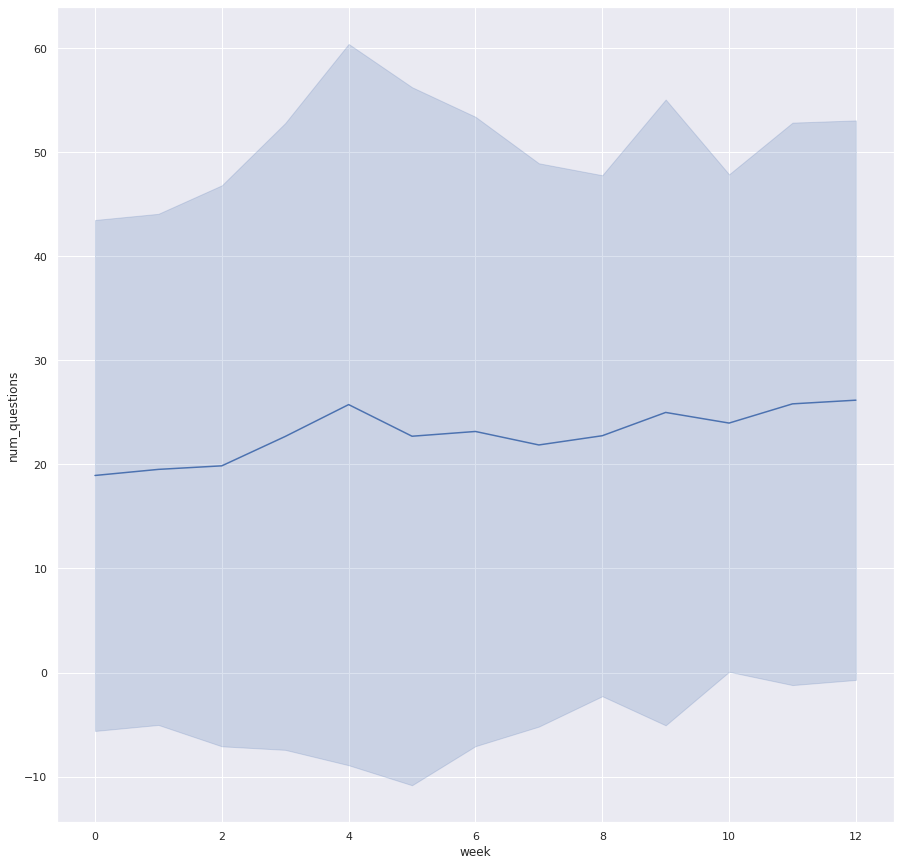

In [17]:
#num_questions

sns.lineplot(data=df_weekly, x="week", y="num_questions", ci='sd')

Analysis: While this time serie does have a general upward trend, there is a lot more variance than what I expected; the confidence interval almost span the entire graph. Thus there is a lot more variation between students than I expected.

Feature: Percentage correct; I also expect a steady increase over the dataset, as students come to grip with the tool and course.

<AxesSubplot:xlabel='week', ylabel='percentage_correct'>

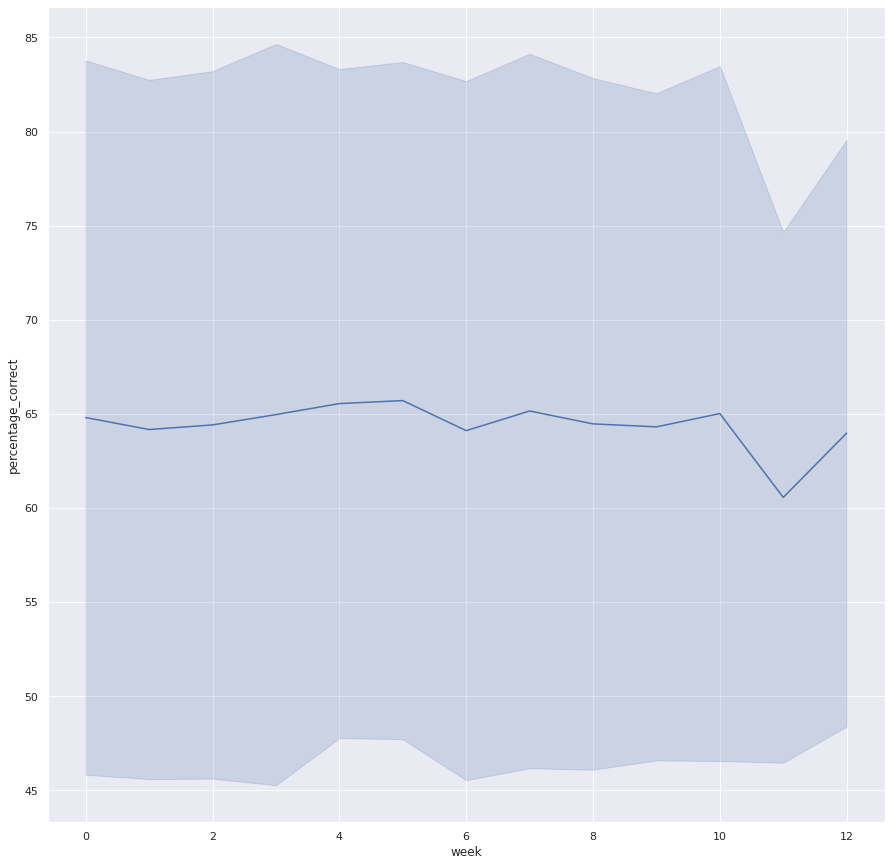

In [18]:
sns.lineplot(data=df_weekly, x="week", y="percentage_correct", ci='sd')

Analysis: Again, a lot more variation than expected, and it follows a pretty flat trend overall, which goes somewhat downward near the end, against what I hypothesised. The average trend is around 65%, which is very close to the passing grade in Switzerland, as explained earlier; Maybe the difficulty of the questions is made explicitely to target this distribution (Gaussian centered at the passing grade). Interestingly, week 11 has a dip of around 5%, maybe due to a harder week in one of the main class level.

# Task 4: Creative extension 

Please provide **one** new hypothesis you would like to explore with the data and visualization for it. Discuss your results: what do you observe? Do the results confirm your hypotheses? 



I'd like to explore the relationship between question type and the average success that student have. I expect to see some question types to have a higher percentage of correctness amongst students, and some lower, but still not far off from the average of 66%.

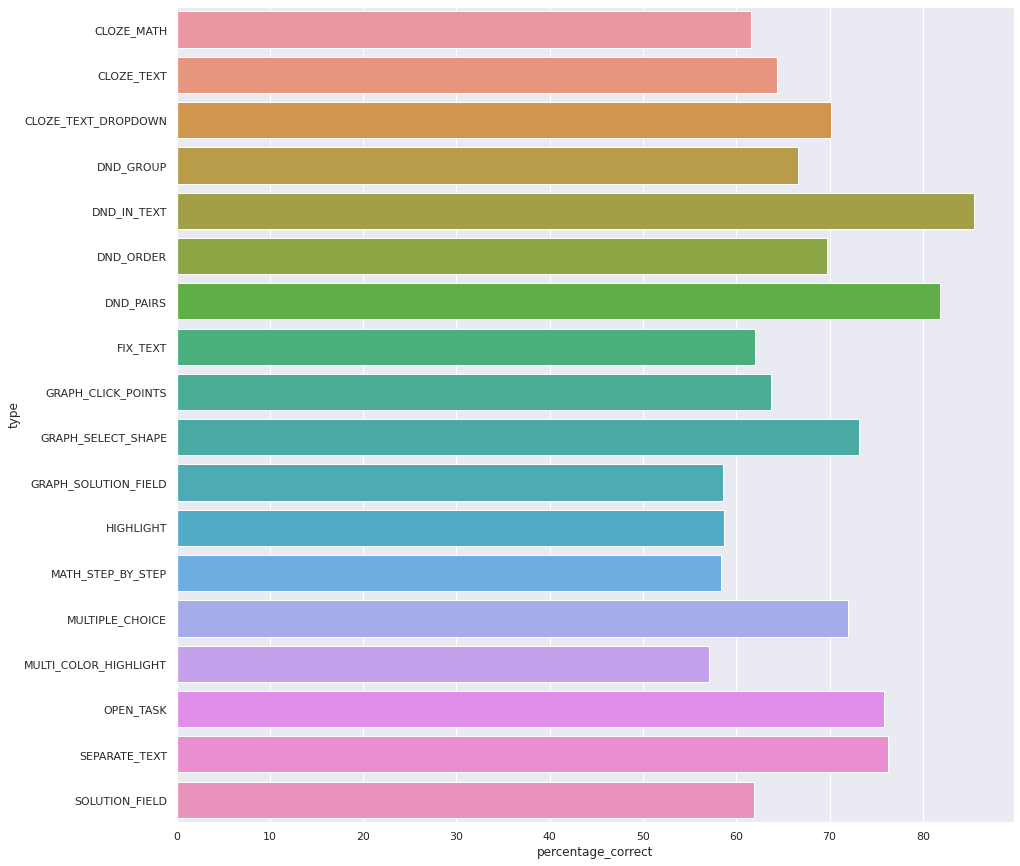

In [19]:
# Your creative visualization here

#Same principle as in Task 2.a), I map evaluation to scores between 0 and 1, and then sum them up per type of questions
df_type = transactions[["type","evaluation"]].dropna().replace(["CORRECT","PARTIAL","WRONG"],[1,0.5,0]).groupby("type").sum().reset_index()

#Merging with the number of question per type of question
df_type = df_type.merge(transactions[["type","evaluation"]].dropna()
              .groupby("type").size().rename('num_questions'), on = "type", how = "left")
#Getting the percentage
df_type["evaluation"] = 100* (df_type["evaluation"]/df_type["num_questions"])

df_type = df_type.rename(columns={"evaluation": "percentage_correct"})

g=sns.barplot(x="percentage_correct", y="type",data=df_type)

As we can see, there are indeed question types that get lower scores, and some that get higher. What is interesting is that the lower ones hover around 60%, but the ones above average gets up to the 80%, which is comparatively higher. So students definitively have an easier time answering certain type of question. I would like to theorize as to why some types of questions are easier, but unfortunately I do not have the details on what these types of questions actually are.